![car](car.jpg)

Insurance companies invest a lot of [time and money](https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf) into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

Knowing all of this, On the Road car insurance have requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

**Librairies**

In [2]:
# Import required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit
import missingno as msg
from statsmodels.graphics.mosaicplot import mosaic

# Start coding!

**Functions**

In [201]:
def list_independants(df, independant_list=None):
    independants=((df.columns.to_list()))
    dict_col={}
    for val in independants:
        dict_col[val]=((val.replace(" ","")).replace("-","_")).replace("+","_")
    df.rename(columns=dict_col, inplace=True)
    independants=((df.columns.to_list()))
    independants.remove("id")
    independants.remove("outcome")
    
    independant=""
    
    for val in independant_list:
        if independant == "":
            independant=val
        else:
            independant=independant+" + "+str(val)
    
    return df, independants, independant

def get_accuracy(matrix):
    TN = matrix[0,0]
    TP = matrix[1,1]
    FN = matrix[1,0]
    FP = matrix[0,1]
    acc = (TN + TP) / (TN + TP + FN + FP)
    return acc

def get_best(dict_model):
    bestfeat="vide"
    bestscore=0
    for key in dict_model.keys():
        if dict_model[key]>=bestscore:
            bestscore=dict_model[key]
            bestfeat=str(key)
    return bestfeat, bestscore

**1. Reading in and exploring the dataset**

In [3]:
df=pd.read_csv('car_insurance.csv')
print(df.head())
print(df.dtypes)
for val in df.columns:
    print(df[val].value_counts())

       id  age  gender  ... duis past_accidents outcome
0  569520    3       0  ...    0              0     0.0
1  750365    0       1  ...    0              0     1.0
2  199901    0       0  ...    0              0     0.0
3  478866    0       1  ...    0              0     0.0
4  731664    1       1  ...    0              1     1.0

[5 rows x 18 columns]
id                       int64
age                      int64
gender                   int64
driving_experience      object
education               object
income                  object
credit_score           float64
vehicle_ownership      float64
vehicle_year            object
married                float64
children               float64
postal_code              int64
annual_mileage         float64
vehicle_type            object
speeding_violations      int64
duis                     int64
past_accidents           int64
outcome                float64
dtype: object
569520    1
702473    1
426507    1
386239    1
454670    1
         

In [4]:
df

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,1,0,10-19y,university,upper class,0.582787,1.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,1,0.0
9996,910346,1,0,10-19y,none,middle class,0.522231,1.0,after 2015,0.0,1.0,32765,NaN,sedan,1,0,0,0.0
9997,468409,1,1,0-9y,high school,middle class,0.470940,1.0,before 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,0.0
9998,903459,1,0,10-19y,high school,poverty,0.364185,0.0,before 2015,0.0,1.0,10238,13000.0,sedan,2,0,1,1.0


**2. Filling missing values**

In [203]:
mean_credit_score=df["credit_score"].mean()
mean_annual_mileage=df["annual_mileage"].mean()

df.fillna({"credit_score":mean_credit_score,"annual_mileage":mean_annual_mileage},inplace=True)

df_na=df[df["credit_score"].isna()|df["annual_mileage"].isna()]
print(df.isna().sum())

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
dtype: int64


AxesSubplot(0.125,0.11;0.698618x0.77)


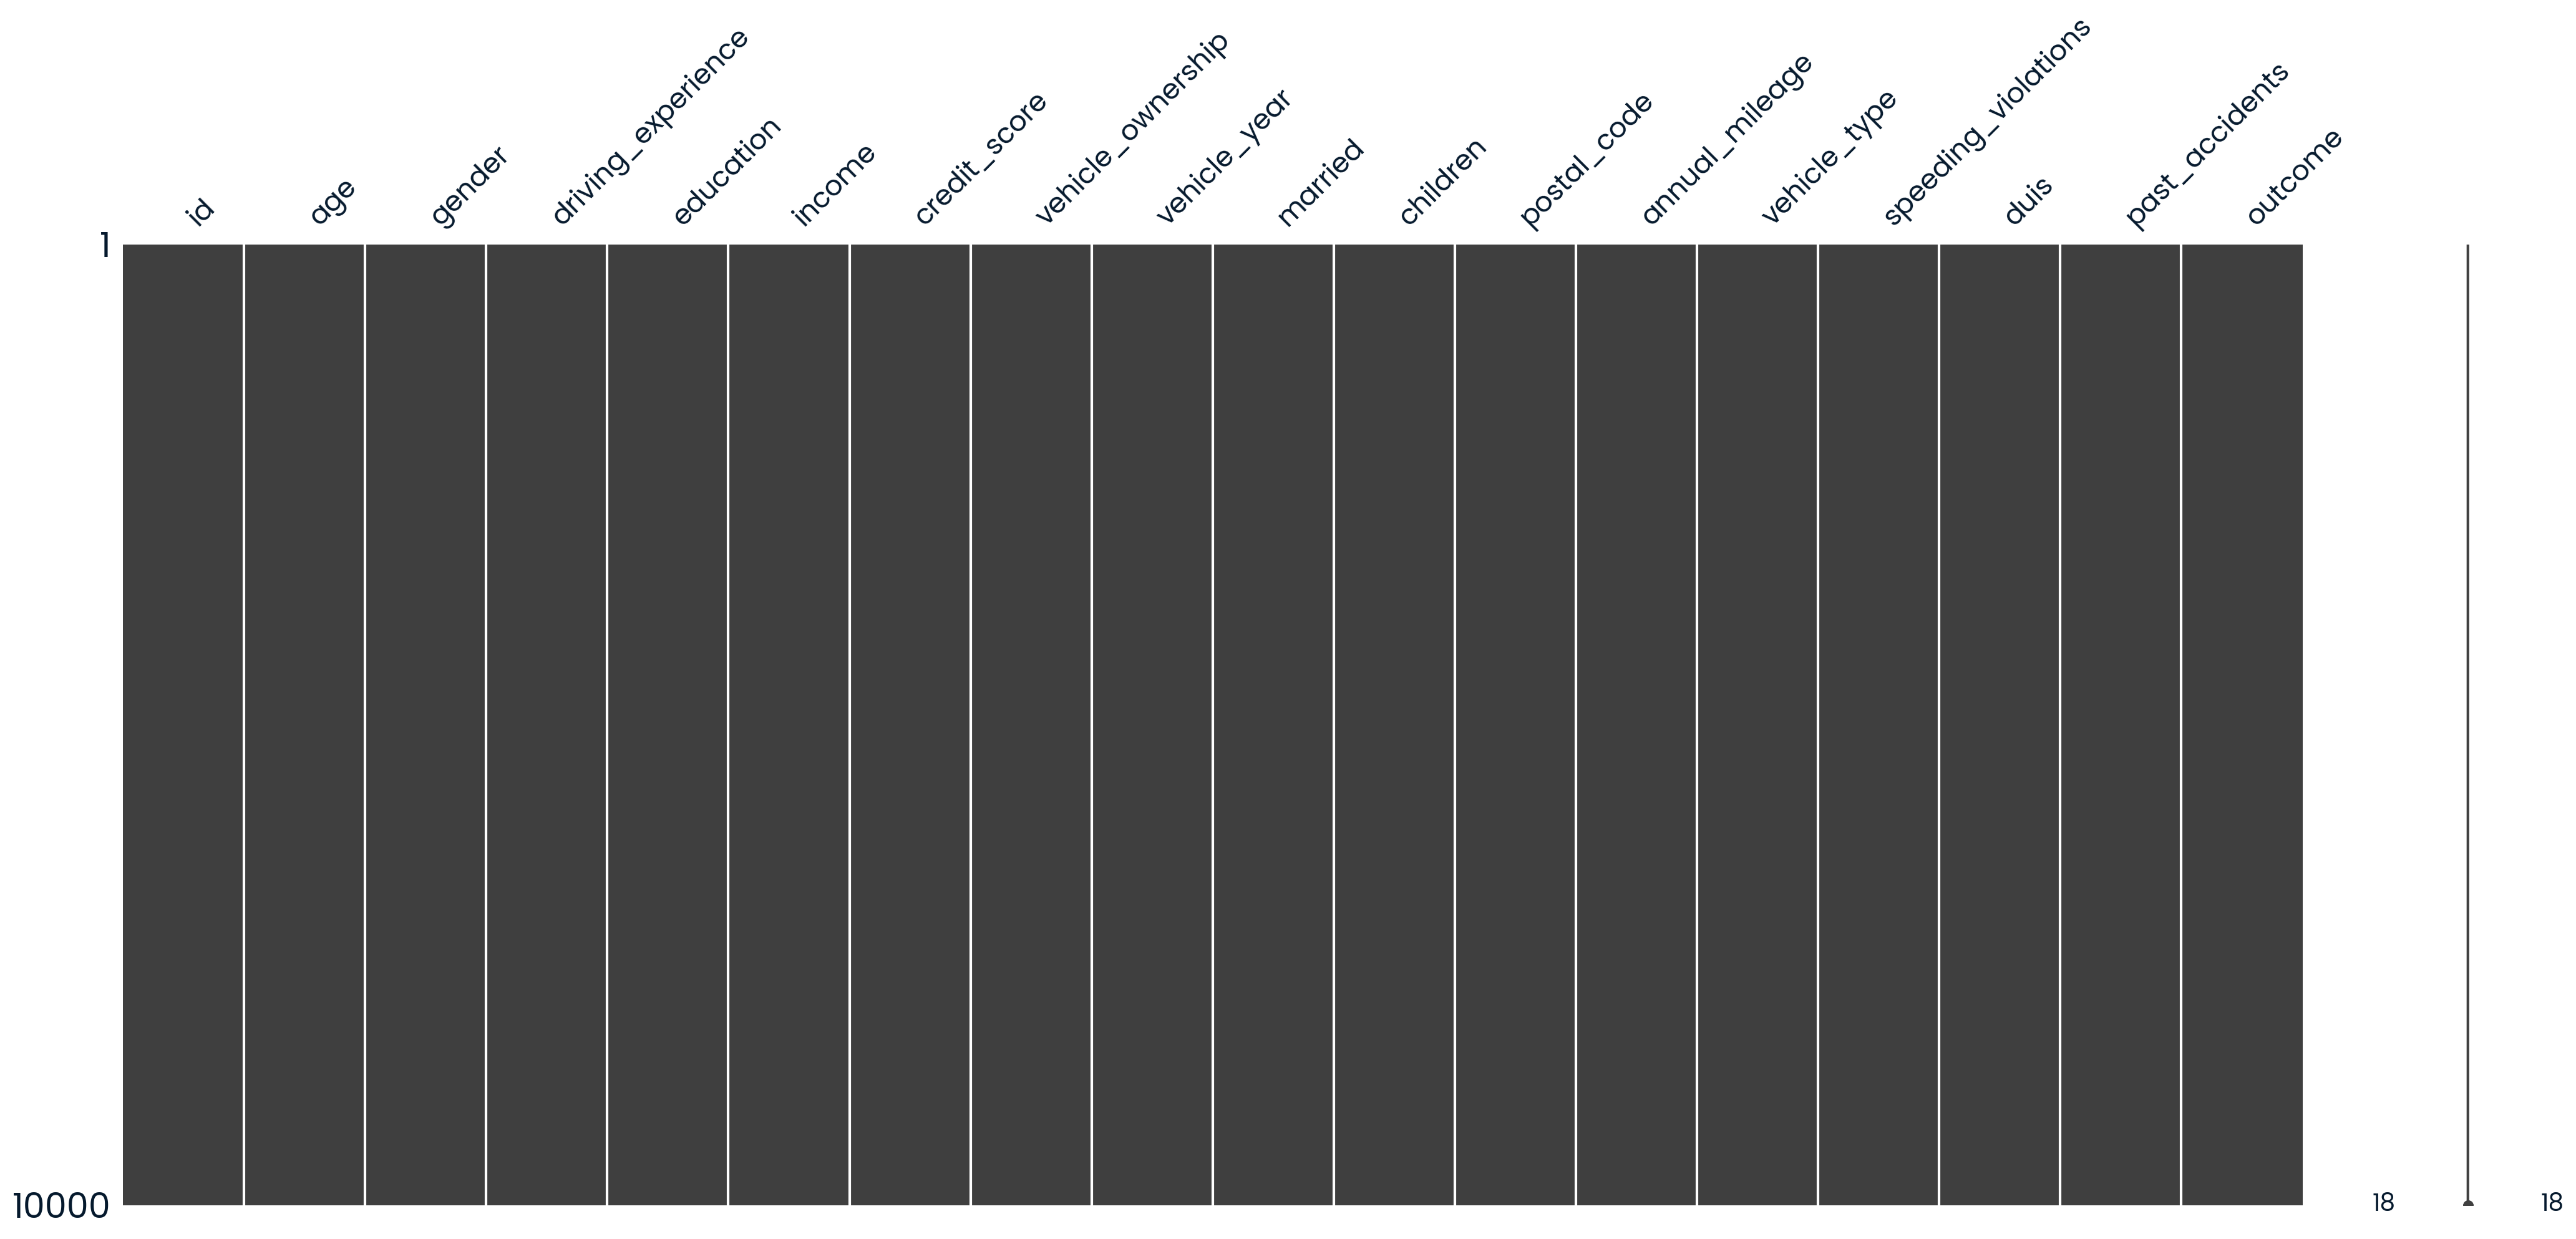

In [204]:
print(msg.matrix(df))

**3. Preparing for modeling**

## **Update Data Type**

In [205]:
list_object=[]
for val in df.columns:
    if(df[val].dtypes=="object"):
        list_object.append(val)
print(list_object)

dict_type={}
dict_type['driving_experience']='category'
dict_type['education']='category'
dict_type['income']='category'
dict_type['vehicle_year']='category'
dict_type['vehicle_type']='category'

for key in dict_type:
    df[key]=df[key].astype(dict_type[key])


['driving_experience', 'education', 'income', 'vehicle_year', 'vehicle_type']


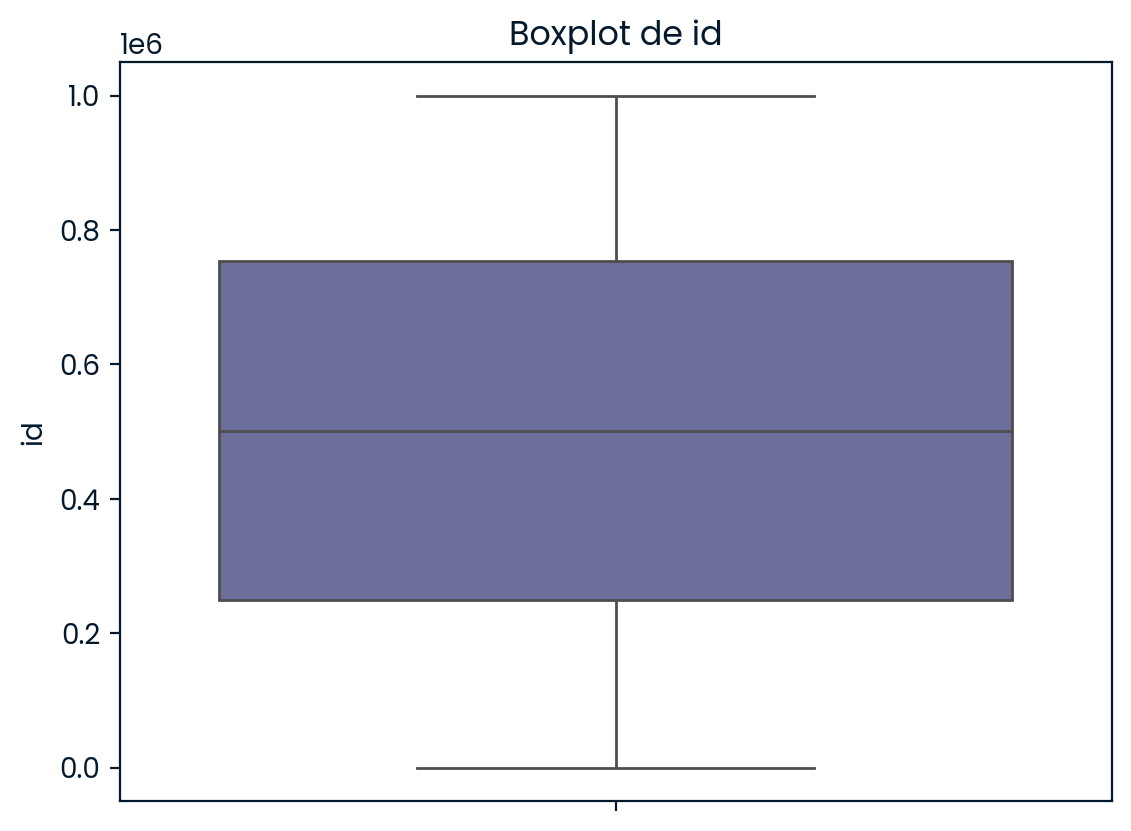

count     10000.000000
mean     500521.906800
std      290030.768758
min         101.000000
25%      249638.500000
50%      501777.000000
75%      753974.500000
max      999976.000000
Name: id, dtype: float64
569520    1
702473    1
426507    1
386239    1
454670    1
         ..
931908    1
672440    1
297005    1
559584    1
442696    1
Name: id, Length: 10000, dtype: int64


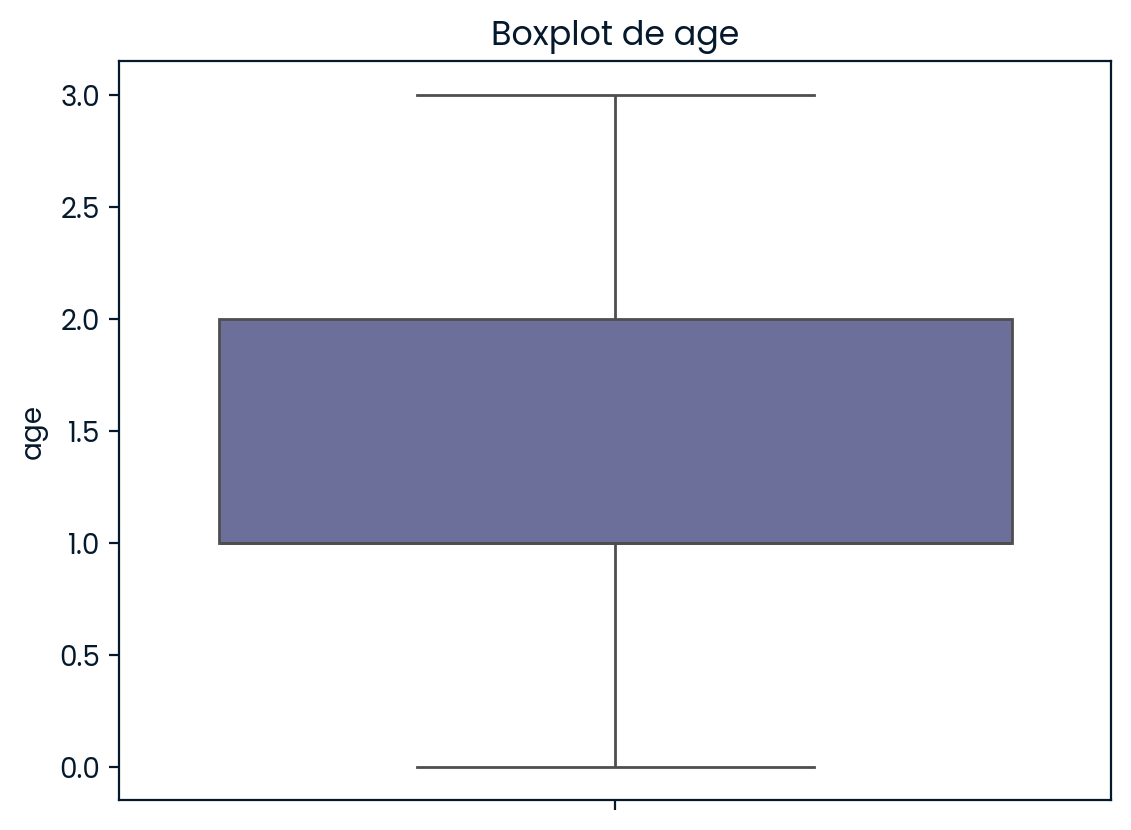

count    10000.000000
mean         1.489500
std          1.025278
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: age, dtype: float64
1    3063
2    2931
0    2016
3    1990
Name: age, dtype: int64


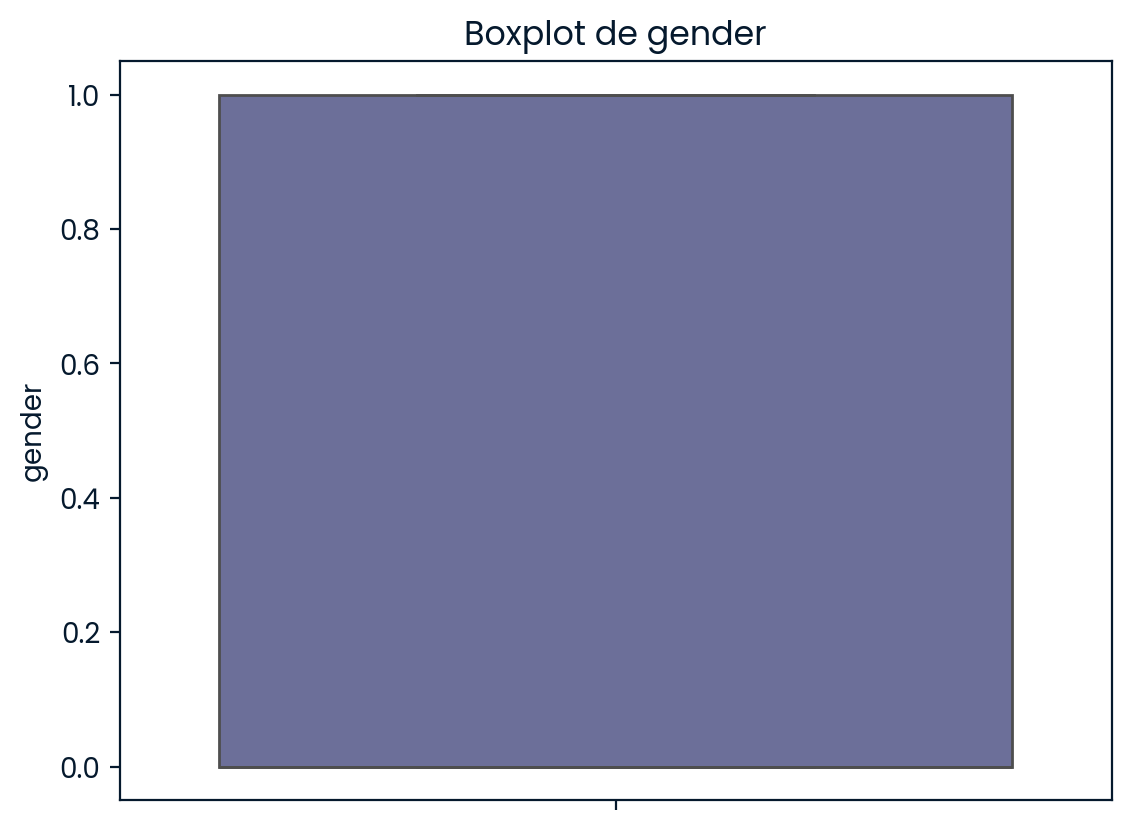

count    10000.000000
mean         0.499000
std          0.500024
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64
0    5010
1    4990
Name: gender, dtype: int64


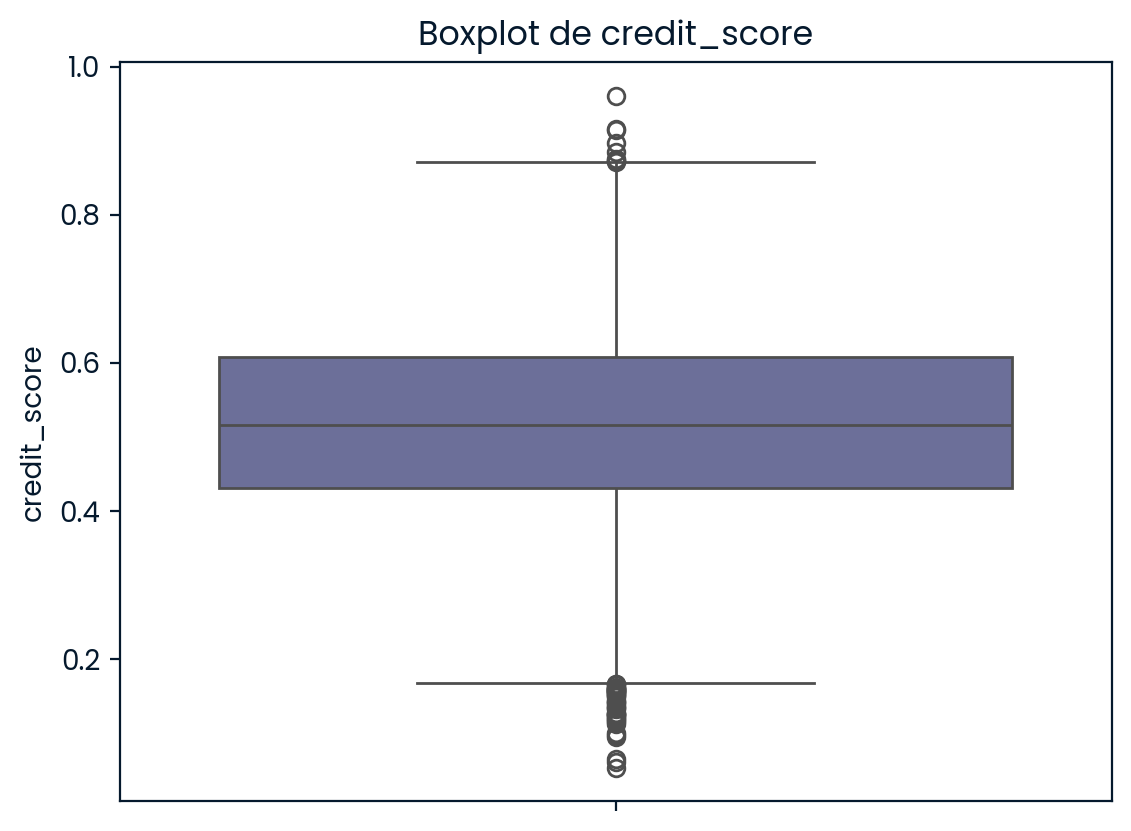

count    10000.000000
mean         0.515813
std          0.130752
min          0.053358
25%          0.431509
50%          0.515813
75%          0.607607
max          0.960819
Name: credit_score, dtype: float64
0.515813    982
0.428487      1
0.594531      1
0.396540      1
0.578306      1
           ... 
0.309272      1
0.847325      1
0.432080      1
0.527041      1
0.435225      1
Name: credit_score, Length: 9019, dtype: int64


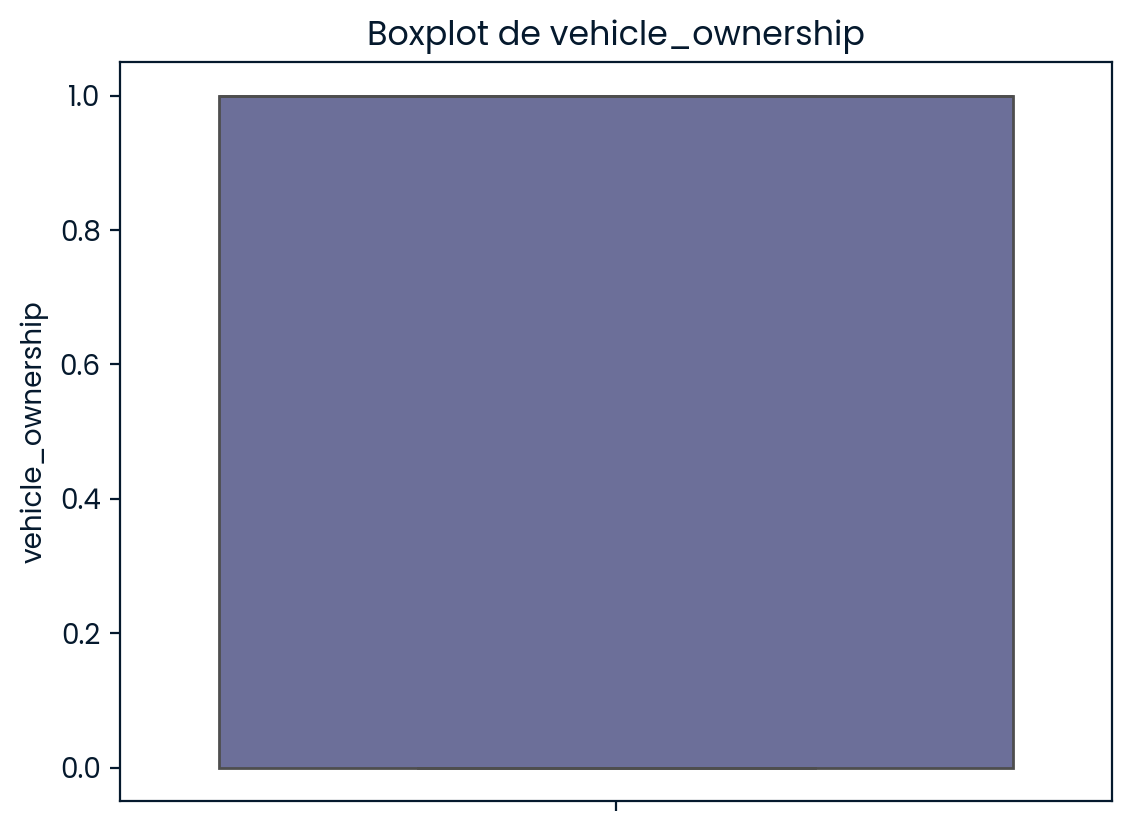

count    10000.000000
mean         0.697000
std          0.459578
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: vehicle_ownership, dtype: float64
1.0    6970
0.0    3030
Name: vehicle_ownership, dtype: int64


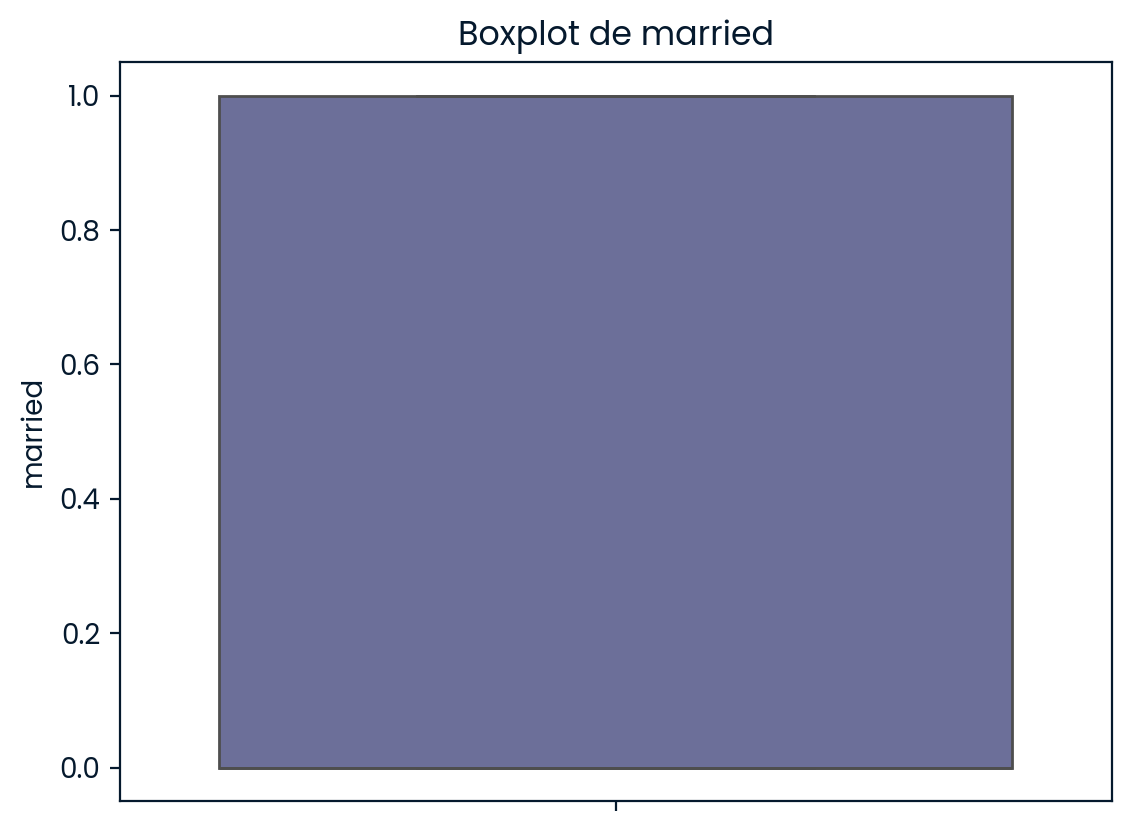

count    10000.000000
mean         0.498200
std          0.500022
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: married, dtype: float64
0.0    5018
1.0    4982
Name: married, dtype: int64


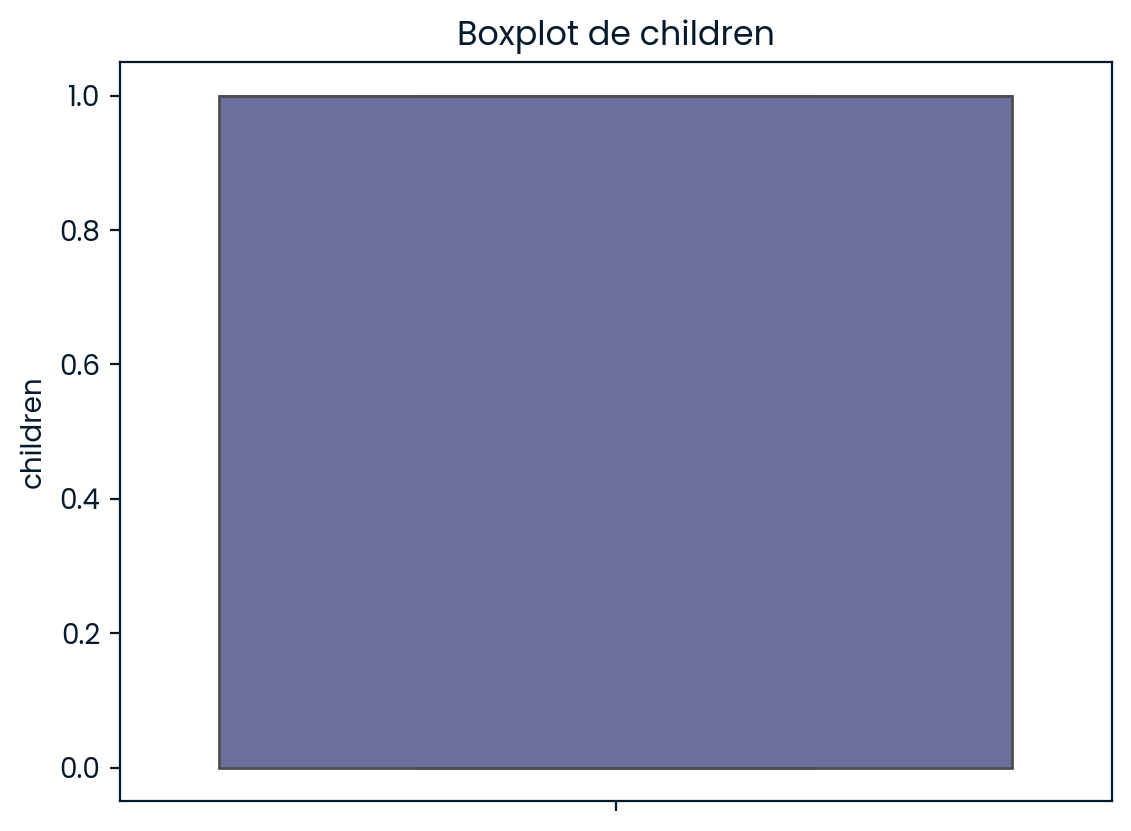

count    10000.000000
mean         0.688800
std          0.463008
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: children, dtype: float64
1.0    6888
0.0    3112
Name: children, dtype: int64


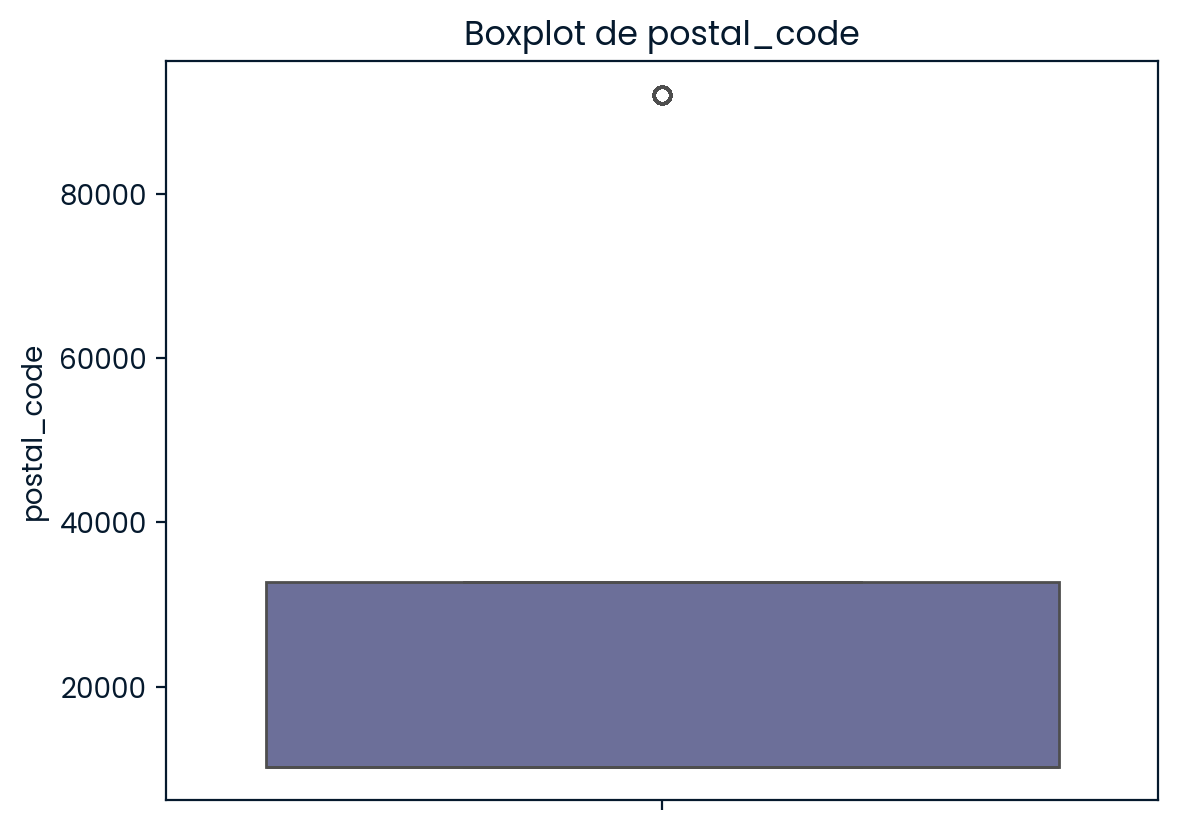

count    10000.000000
mean     19864.548400
std      18915.613855
min      10238.000000
25%      10238.000000
50%      10238.000000
75%      32765.000000
max      92101.000000
Name: postal_code, dtype: float64
10238    6940
32765    2456
92101     484
21217     120
Name: postal_code, dtype: int64


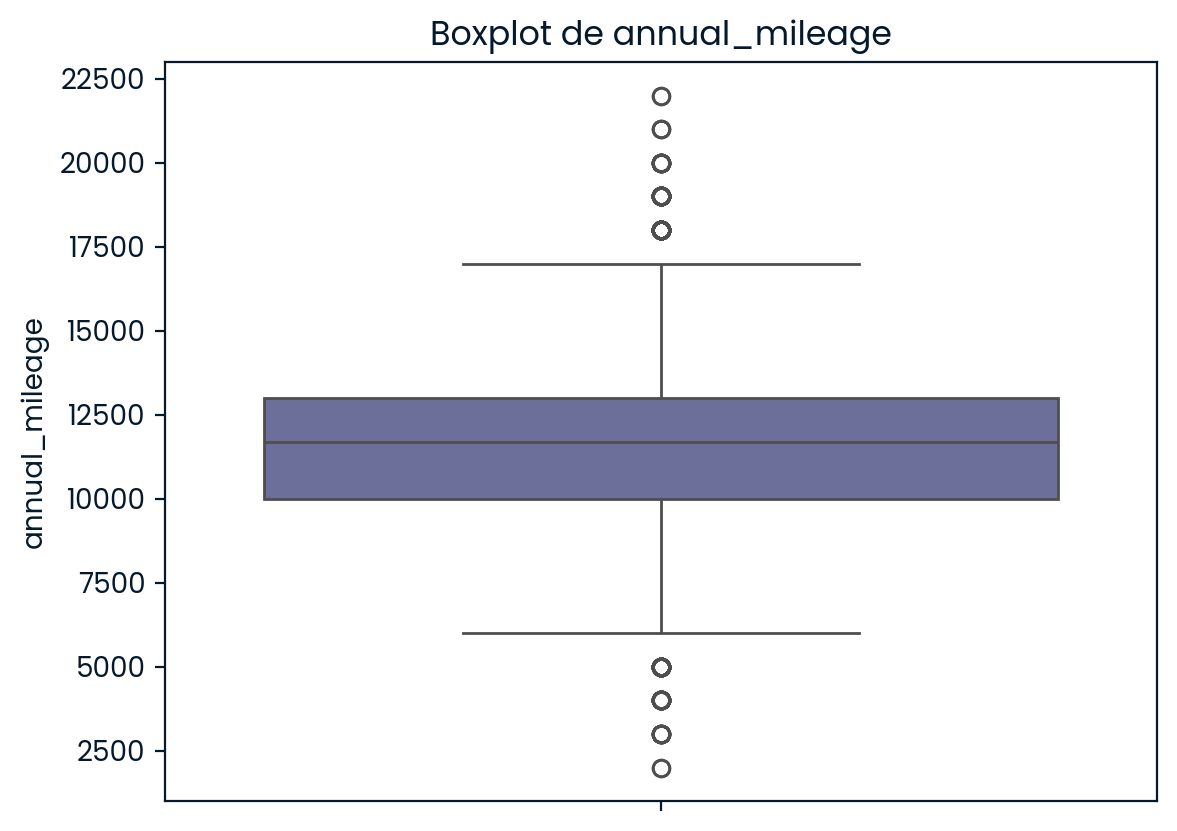

count    10000.000000
mean     11697.003207
std       2680.167384
min       2000.000000
25%      10000.000000
50%      11697.003207
75%      13000.000000
max      22000.000000
Name: annual_mileage, dtype: float64
11000.000000    1253
12000.000000    1218
13000.000000    1137
10000.000000    1071
11697.003207     957
14000.000000     894
9000.000000      856
15000.000000     632
8000.000000      557
16000.000000     419
7000.000000      322
17000.000000     246
6000.000000      165
18000.000000     103
5000.000000       65
19000.000000      48
4000.000000       27
20000.000000      13
3000.000000       10
21000.000000       3
2000.000000        2
22000.000000       2
Name: annual_mileage, dtype: int64


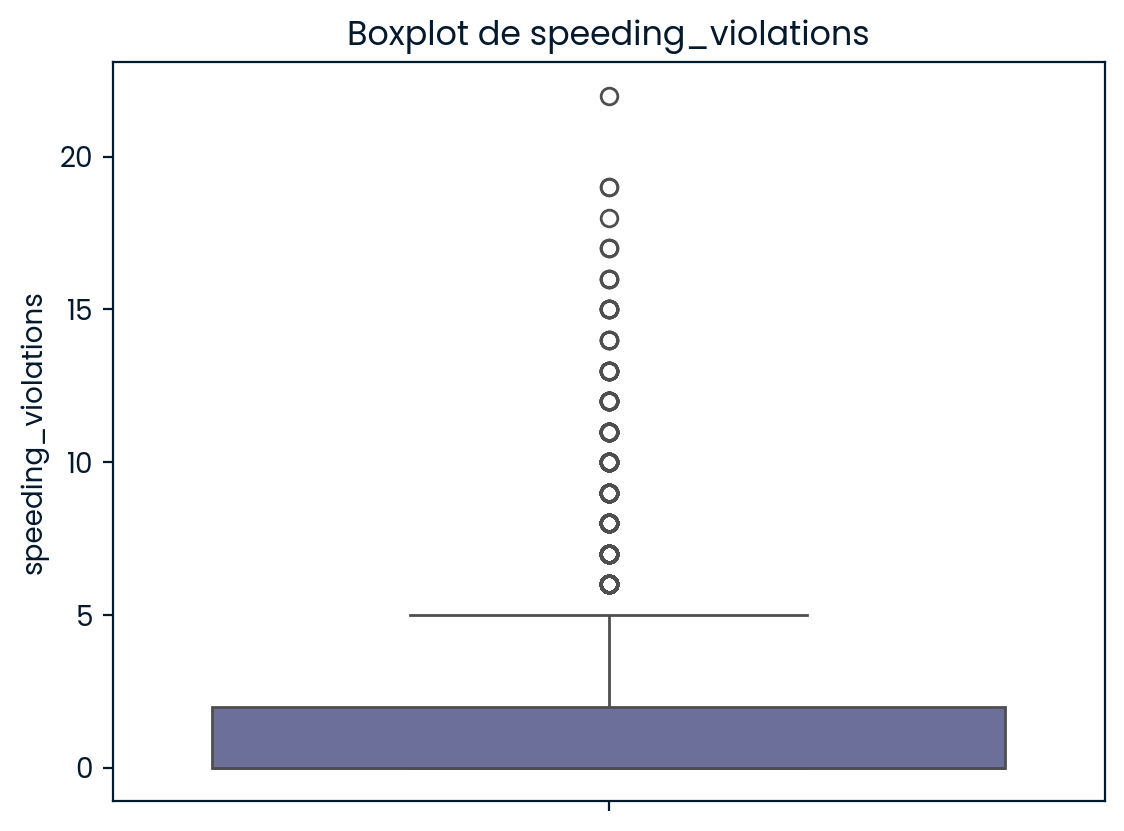

count    10000.000000
mean         1.482900
std          2.241966
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         22.000000
Name: speeding_violations, dtype: float64
0     5028
1     1544
2     1161
3      830
4      530
5      319
6      188
7      140
8       75
10      50
9       49
11      30
12      20
13      12
15       8
14       5
16       4
17       3
19       2
18       1
22       1
Name: speeding_violations, dtype: int64


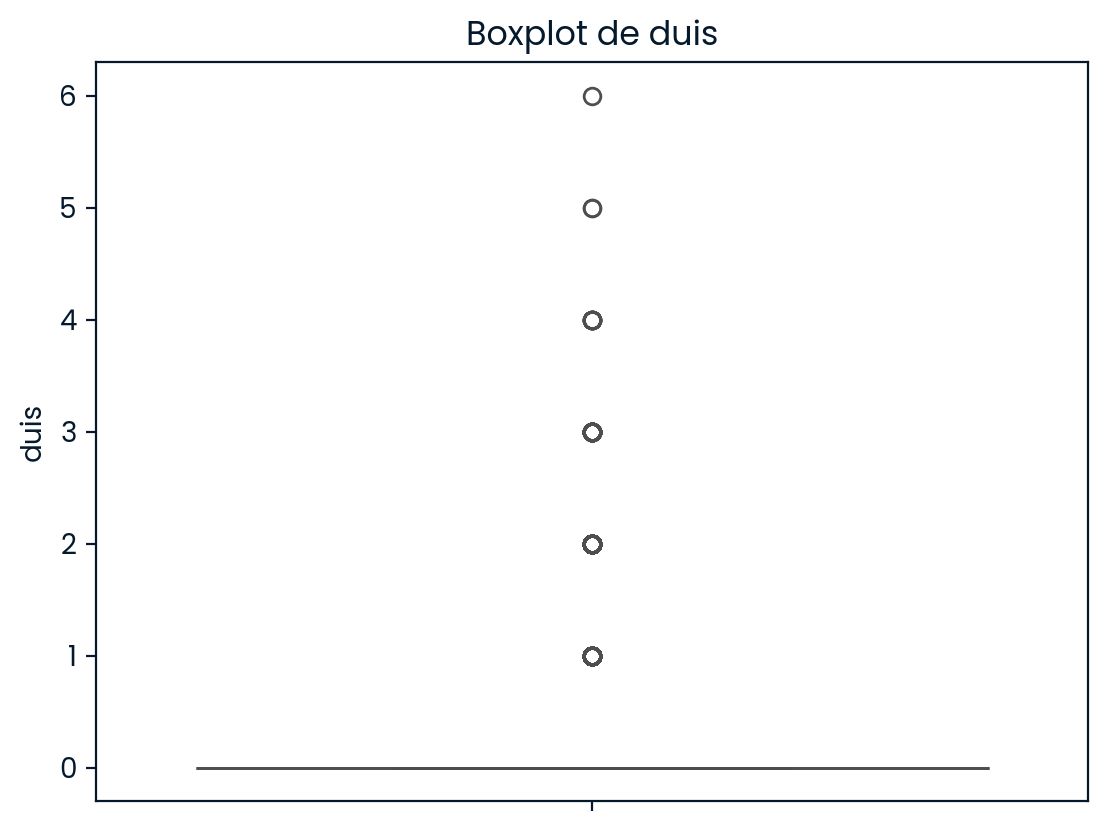

count    10000.00000
mean         0.23920
std          0.55499
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          6.00000
Name: duis, dtype: float64
0    8118
1    1470
2     331
3      68
4      10
5       2
6       1
Name: duis, dtype: int64


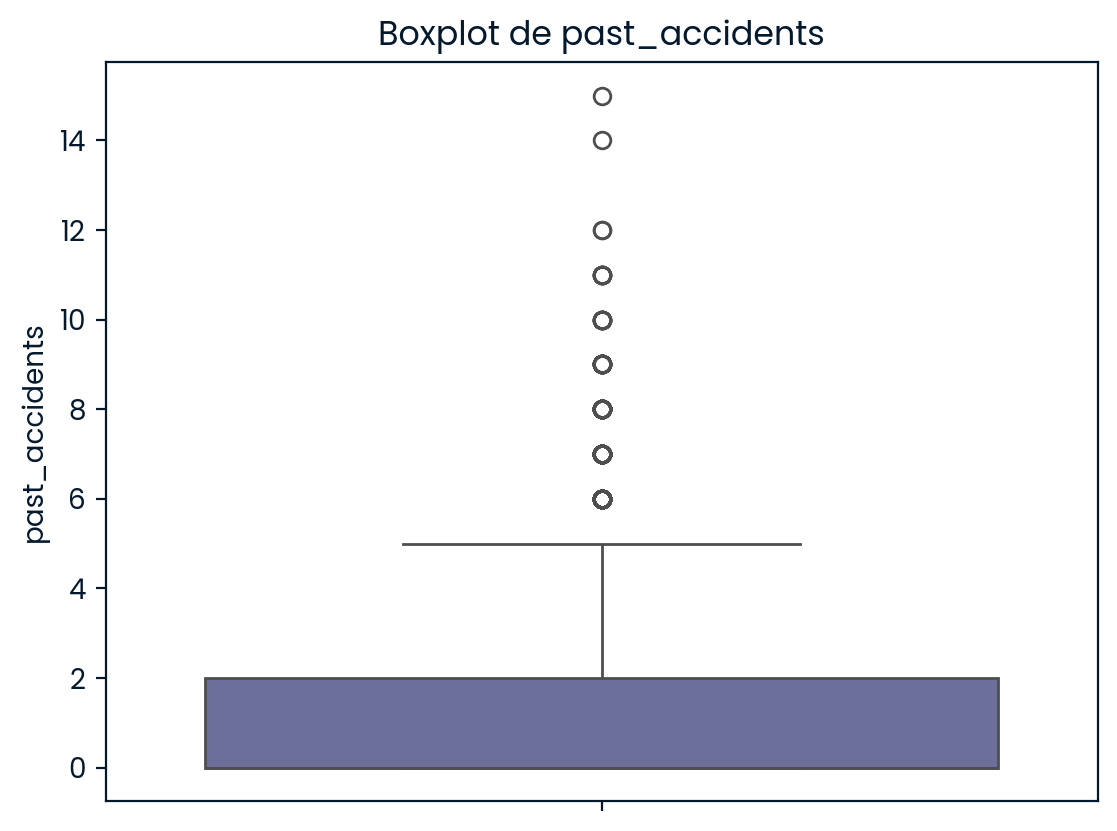

count    10000.000000
mean         1.056300
std          1.652454
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         15.000000
Name: past_accidents, dtype: float64
0     5584
1     1783
2     1104
3      646
4      366
5      232
6      144
7       61
8       41
9       19
10       9
11       7
12       2
14       1
15       1
Name: past_accidents, dtype: int64


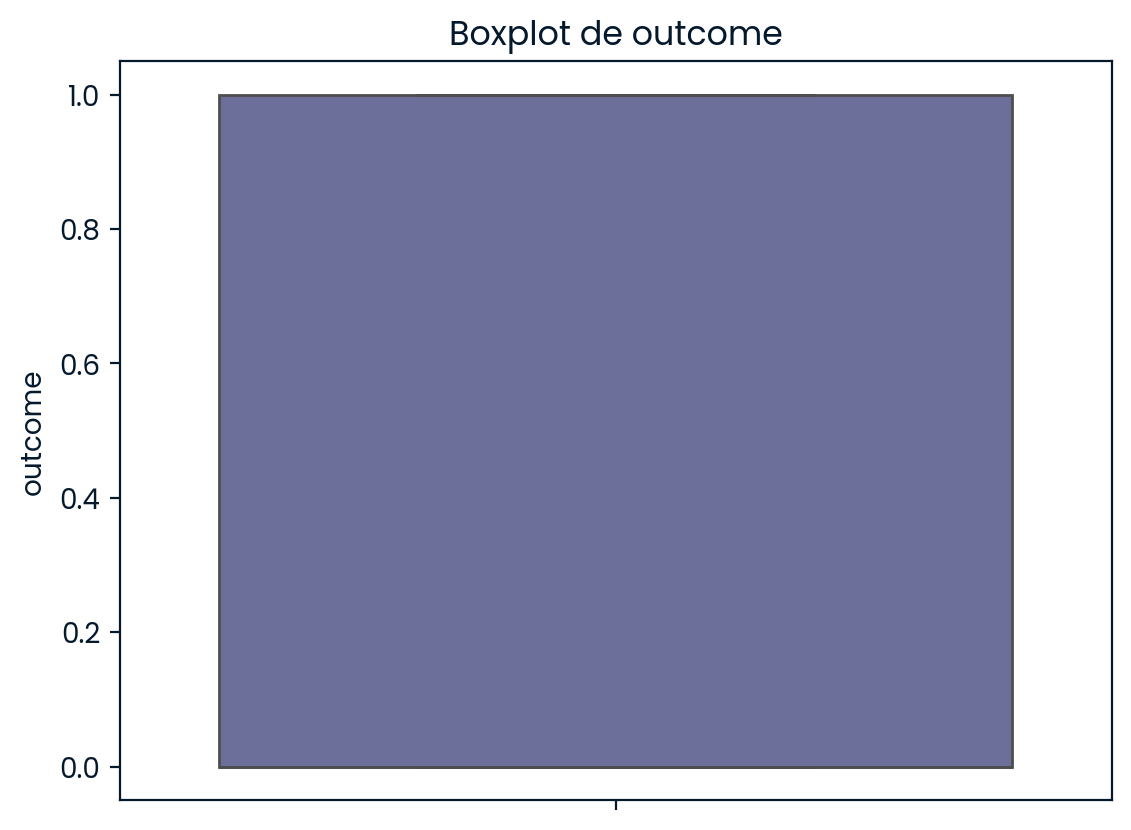

count    10000.000000
mean         0.313300
std          0.463858
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: outcome, dtype: float64
0.0    6867
1.0    3133
Name: outcome, dtype: int64


In [206]:
list_box=[]
for val in df.columns:
    if((df[val].dtypes=="int64")|(df[val].dtypes=="float64")):
        plt.figure()
        sns.boxplot(data=df[val])
        plt.title(f'Boxplot de {val}')
        plt.show()
        print(df[val].describe())
        print(df[val].value_counts())

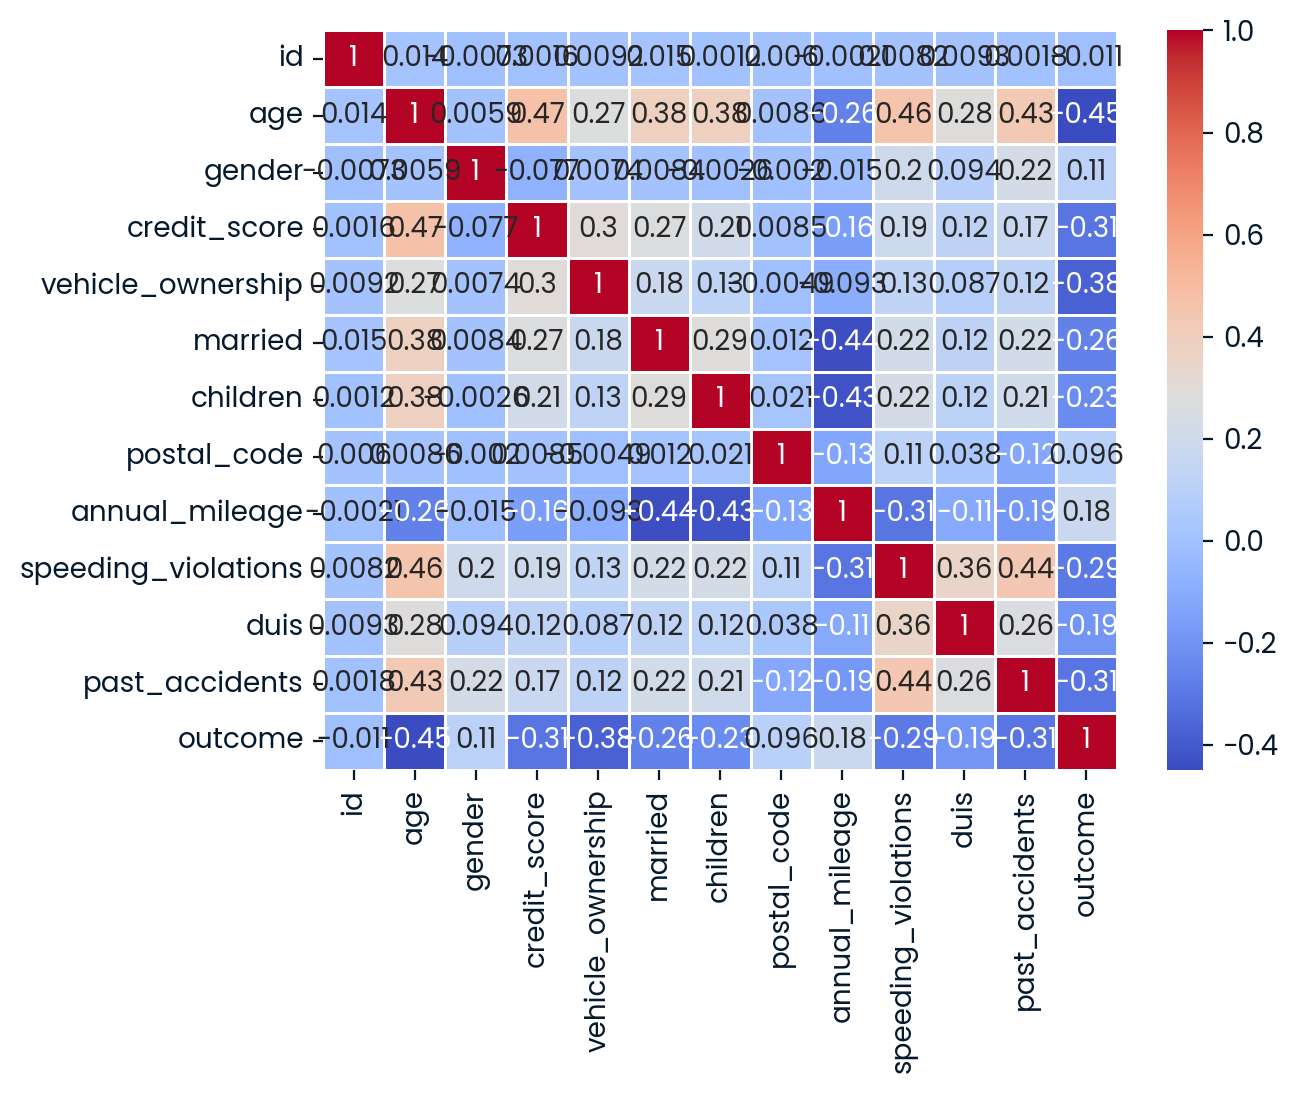

In [207]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

**4. Building and storing the models**

In [208]:

dependant='outcome'

df_enconded=pd.get_dummies(df, columns=list_object, drop_first=True)

df_enconded, independants, independant=list_independants(df,"Vide")


dict_res={}

for val in independants:
    model=logit((dependant+' ~ '+val),data=df_enconded).fit()
    matrix=model.pred_table()
    dict_res[val]=get_accuracy(matrix)


    

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.603742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595431
  

In [209]:
dict_res

{'age': 0.7747,
 'gender': 0.6867,
 'driving_experience': 0.7771,
 'education': 0.6867,
 'income': 0.7425,
 'credit_score': 0.7054,
 'vehicle_ownership': 0.7351,
 'vehicle_year': 0.6867,
 'married': 0.6867,
 'children': 0.6867,
 'postal_code': 0.6867,
 'annual_mileage': 0.6904,
 'vehicle_type': 0.6867,
 'speeding_violations': 0.6867,
 'duis': 0.6867,
 'past_accidents': 0.6867}

**5. Measuring performance**

In [210]:
bestfeat=get_best(dict_res)[0]
bestscore=get_best(dict_res)[1]

**6. Finding the best performing model**

In [211]:
best_feature_df=pd.DataFrame({"best_feature":[bestfeat],"best_accuracy":[bestscore]},index=[0])
model=logit((dependant+' ~ '+bestfeat),data=df_enconded).fit()
df_pred=df_enconded.assign(pred_outcome=model.predict(df_enconded))
df_pred["pred_outcome_round"]=np.round(df_pred["pred_outcome"])
print(best_feature_df)
matrix=model.pred_table()
print(matrix)

Optimization terminated successfully.
         Current function value: 0.467092
         Iterations 8
         best_feature  best_accuracy
0  driving_experience         0.7771
[[5554. 1313.]
 [ 916. 2217.]]
